# Data Preparation for Sportsmanship Player

In this notebook we will prepare the data for the Kim Perrot Sportsmanship Award prediction.

#### Load Dependencies

In [15]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('..')

from data_scripts import _store_data as sd
from pathlib import Path

sd.load_data(Path("../data"))

#### Copy and Prepare Player Data

This section prepares player sportsmanship-related statistics for analysis:

- **Copy Dataset:** Create a copy of the original player-team dataset to preserve the source data.  
- **Convert Key Stats to Float:** Ensure personal fouls, disqualifications, and minutes are numeric for calculations.  
- **Aggregate by Player and Year:** Group the data by player and year, summing stats to get yearly totals per player.  
- **Add Season 11 Data:** Include additional data from Season 11 for completeness.

In [16]:
sportsmanship_players_info_df = sd.players_teams_df.copy()

cols_to_agg = ['PF', 'dq', 'minutes']

for col in cols_to_agg:
    sportsmanship_players_info_df[col] = sportsmanship_players_info_df[col].astype(float)

sportsmanship_players_info_df = sportsmanship_players_info_df.groupby(['playerID', 'year'], as_index=False)[cols_to_agg].sum()

# Adding data from Season 11
players_teams_year11_df = pd.read_csv("../basketballPlayoffs/Season_11/players_teams.csv")[['playerID', 'year']]

sportsmanship_players_info_df = pd.concat([sportsmanship_players_info_df, players_teams_year11_df], ignore_index=True)

#### Calculate Player Sportsmanship Score

This section computes a sportsmanship score based on fouls and disqualifications:

- **Define Score Function:** Create a function that calculates a score from personal fouls, disqualifications, and minutes played.  
- **Apply Function:** Generate sportsmanship scores for each player per season.  
- **Sort Data:** Organize by player and year for lagged feature creation.  
- **Create Lagged Scores:** Add previous 1-3 year scores as features for modeling.

In [17]:
def calculate_player_sportsmanship_score(sportsmanship_players_info_df):
    sportsmanship_players_info_df['score'] = np.where(
        (sportsmanship_players_info_df['minutes'] != 0) &
        (sportsmanship_players_info_df['PF'] != 0),
        (
            (sportsmanship_players_info_df['PF'] + 25 * sportsmanship_players_info_df['dq'])
            / sportsmanship_players_info_df['minutes']
        ) * np.maximum(
            1,
            500 / sportsmanship_players_info_df['minutes']
        ),
        0
    )

    return sportsmanship_players_info_df

sportsmanship_players_info_df = calculate_player_sportsmanship_score(sportsmanship_players_info_df)

sportsmanship_players_info_df = sportsmanship_players_info_df.sort_values(
    ['playerID', 'year']
)

for i in range(1, 4):
    sportsmanship_players_info_df[f'prev_score_{i}'] = (
        sportsmanship_players_info_df
        .groupby('playerID')['score']
        .shift(i)
        .fillna(0)
    )

#### Get Previous Attend of The Player Team

This section adds team attendance from the previous season:

- **Shift Attendance:** Retrieve attendance data from the prior year for each team.  
- **Fill Missing Values:** Handle any missing attendance data with zeros.  
- **Add Feature:** Include this as a potential indicator of team or player context.

In [18]:
sportsmanship_players_info_df["prev_attend"] = sd.teams_df["attend"].shift(1)
sportsmanship_players_info_df["prev_attend"] = sportsmanship_players_info_df["prev_attend"].fillna(0)

#### Merge Kim Perrot Sportsmanship Award Information

This step incorporates the target variable for modeling sportsmanship:

- **Filter Awards:** Identify Kim Perrot Sportsmanship awards from the awards dataset.  
- **Add Indicator:** Create a column marking winners (1) or non-winners (0).  
- **Merge with Players:** Combine award data with the player dataframe.  
- **Prepare for Modeling:** Ensure the dataset includes features and the target variable.

In [19]:
sportsmanship_aw = sd.awards_players_df.loc[
    sd.awards_players_df['award'].str.strip().str.lower() == 'kim perrot sportsmanship award'
].copy()

sportsmanship_aw['sportsmanship'] = 1

sportsmanship_players_info_df = sportsmanship_players_info_df.merge(
    sportsmanship_aw[['playerID', 'year', 'sportsmanship']],
    on=['playerID', 'year'],
    how='left'
)

sportsmanship_players_info_df['sportsmanship'] = (
    sportsmanship_players_info_df['sportsmanship']
        .fillna(0)
        .astype(int)
)

#### Remove Columns and Save CSV

This step finalizes the sportsmanship dataset:

- **Drop Unnecessary Columns:** Remove raw stats and irrelevant features to focus on key data.  
- **Save to CSV:** Export the processed dataset to a CSV file for predictive modeling.  
- **Ready for Analysis:** The dataset is now clean and contains features for sportsmanship award prediction.

In [20]:
columns_to_drop = [
    'GP', 'GS', 'minutes', 'points', 'oRebounds', 'dRebounds',
    'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'PF',
    'fgMade', 'fgAttempted', 'threeMade', 'threeAttempted',
    'ftMade', 'ftAttempted', 'PostthreeMade', 'PostthreeAttempted',
    'dq', 'PostGP', 'PostGS', 'PostMinutes', 'PostPoints', 'PostoRebounds',
    'PostdRebounds', 'PostRebounds', 'PostAssists', 'PostSteals', 'PostBlocks',
    'PostTurnovers', 'PostPF', 'PostfgMade', 'PostfgAttempted', 'PostthreeMade',
    'PostthreeAttempted', 'PostftMade', 'PostftAttempted', 'PostDQ',
    'height', 'weight', 'pos', 'birthDate', 'deathDate', 'score'
]

sportsmanship_players_info_df.drop(columns=[col for col in columns_to_drop if col in sportsmanship_players_info_df.columns], inplace=True)

sportsmanship_players_info_df.to_csv("../predict_datasets/kpsa.csv", index=False)

#### Idea For the Dataset Prediction

Since this is the Sportsmanship Award dataset, it is important to recognize that the award criteria extend beyond in-game statistics to include conduct that is not quantitatively captured, such as refraining from trash talk, showing respect for opponents and officials, and demonstrating overall integrity. Since such behavioral data is unavailable in our dataset, we have chosen to focus on the measurable in-game statistics most relevant to sportsmanlike conduct.

Specifically, we have calculated a composite score using personal fouls and disqualifications, as lower values in these categories typically reflect better on-court discipline and restraint.

Furthermore, to ensure that minimal playing time does not unduly inflate a candidate's sportsmanship score, we have incorporated a minutes played component. This adjustment balances the impact of low foul counts against players with significantly greater court exposure, while also accounting for the lower public recognition of the players with low minutes.

#### Data Correlation Analysis

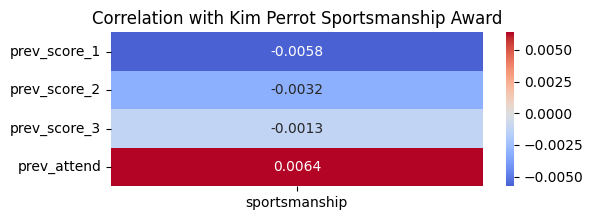

In [21]:
score_cols = ['prev_score_1', 'prev_score_2', 'prev_score_3', 'prev_attend', 'sportsmanship']
df_scores = sportsmanship_players_info_df[score_cols]

corr_matrix = df_scores.corr()[['sportsmanship']]

corr_matrix = corr_matrix.drop('sportsmanship')

plt.figure(figsize=(6, len(corr_matrix)/2))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation with Kim Perrot Sportsmanship Award")
plt.show()